# Visualizing Model Results

This notebook visualizes the performance of our three projection models:
1. **Marcel Baseline**
2. **IPL-Only ML**
3. **Global ML**

We will look at:
- **2025 Backtest Performance**: Actual vs Predicted scatter plots.
- **2026 Projections**: Comparison of top players.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import r2_score, mean_absolute_error

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def load_data():
    """Load all datasets."""
    project_root = Path('.').resolve().parent
    if str(project_root).endswith('WARprojections'):
        project_root = project_root.parent
        
    data_dir = project_root / 'data'
    results_dir = project_root / 'results' / 'WARprojections'
    
    # Actuals
    bat_actual = pd.read_csv(data_dir / 'batter_war_full_history.csv')
    bat_actual = bat_actual[bat_actual['season'] == 2025][['batter_name', 'WAR']].rename(columns={'batter_name': 'player_name', 'WAR': 'actual_war'})
    
    bowl_actual = pd.read_csv(data_dir / 'bowler_war_full_history.csv')
    bowl_actual = bowl_actual[bowl_actual['season'] == 2025][['bowler_name', 'WAR']].rename(columns={'bowler_name': 'player_name', 'WAR': 'actual_war'})
    
    # Backtests (2025)
    marcel_bat = pd.read_csv(results_dir / 'marcel' / 'batter_projections_2025.csv')[['player_name', 'projected_war_2025']].rename(columns={'projected_war_2025': 'marcel_war'})
    marcel_bowl = pd.read_csv(results_dir / 'marcel' / 'bowler_projections_2025.csv')[['player_name', 'projected_war_2025']].rename(columns={'projected_war_2025': 'marcel_war'})
    
    ipl_bat = pd.read_csv(results_dir / 'batter_backtest_2025.csv')[['batter_name', 'predicted_war']].rename(columns={'batter_name': 'player_name', 'predicted_war': 'ipl_ml_war'})
    ipl_bowl = pd.read_csv(results_dir / 'bowler_backtest_2025.csv')[['bowler_name', 'predicted_war']].rename(columns={'bowler_name': 'player_name', 'predicted_war': 'ipl_ml_war'})
    
    global_bat = pd.read_csv(results_dir / 'batter_backtest_2025_global.csv')[['batter_name', 'predicted_war']].rename(columns={'batter_name': 'player_name', 'predicted_war': 'global_ml_war'})
    global_bowl = pd.read_csv(results_dir / 'bowler_backtest_2025_global.csv')[['bowler_name', 'predicted_war']].rename(columns={'bowler_name': 'player_name', 'predicted_war': 'global_ml_war'})
    
    # Forecasts (2026)
    marcel_bat_26 = pd.read_csv(results_dir / 'marcel' / 'batter_projections_2026.csv')[['player_name', 'projected_war_2026']].rename(columns={'projected_war_2026': 'marcel_war'})
    marcel_bowl_26 = pd.read_csv(results_dir / 'marcel' / 'bowler_projections_2026.csv')[['player_name', 'projected_war_2026']].rename(columns={'projected_war_2026': 'marcel_war'})
    
    ipl_bat_26 = pd.read_csv(results_dir / 'batter_projections_2026.csv')[['batter_name', 'projected_war_2026']].rename(columns={'batter_name': 'player_name', 'projected_war_2026': 'ipl_ml_war'})
    ipl_bowl_26 = pd.read_csv(results_dir / 'bowler_projections_2026.csv')[['bowler_name', 'projected_war_2026']].rename(columns={'bowler_name': 'player_name', 'projected_war_2026': 'ipl_ml_war'})
    
    global_bat_26 = pd.read_csv(results_dir / 'batter_projections_2026_global.csv')[['batter_name', 'projected_war_2026']].rename(columns={'batter_name': 'player_name', 'projected_war_2026': 'global_ml_war'})
    global_bowl_26 = pd.read_csv(results_dir / 'bowler_projections_2026_global.csv')[['bowler_name', 'projected_war_2026']].rename(columns={'bowler_name': 'player_name', 'projected_war_2026': 'global_ml_war'})
    
    return {
        'batter': {
            'actual': bat_actual,
            'backtest': {'marcel': marcel_bat, 'ipl_ml': ipl_bat, 'global_ml': global_bat},
            'forecast': {'marcel': marcel_bat_26, 'ipl_ml': ipl_bat_26, 'global_ml': global_bat_26}
        },
        'bowler': {
            'actual': bowl_actual,
            'backtest': {'marcel': marcel_bowl, 'ipl_ml': ipl_bowl, 'global_ml': global_bowl},
            'forecast': {'marcel': marcel_bowl_26, 'ipl_ml': ipl_bowl_26, 'global_ml': global_bowl_26}
        }
    }

data = load_data()

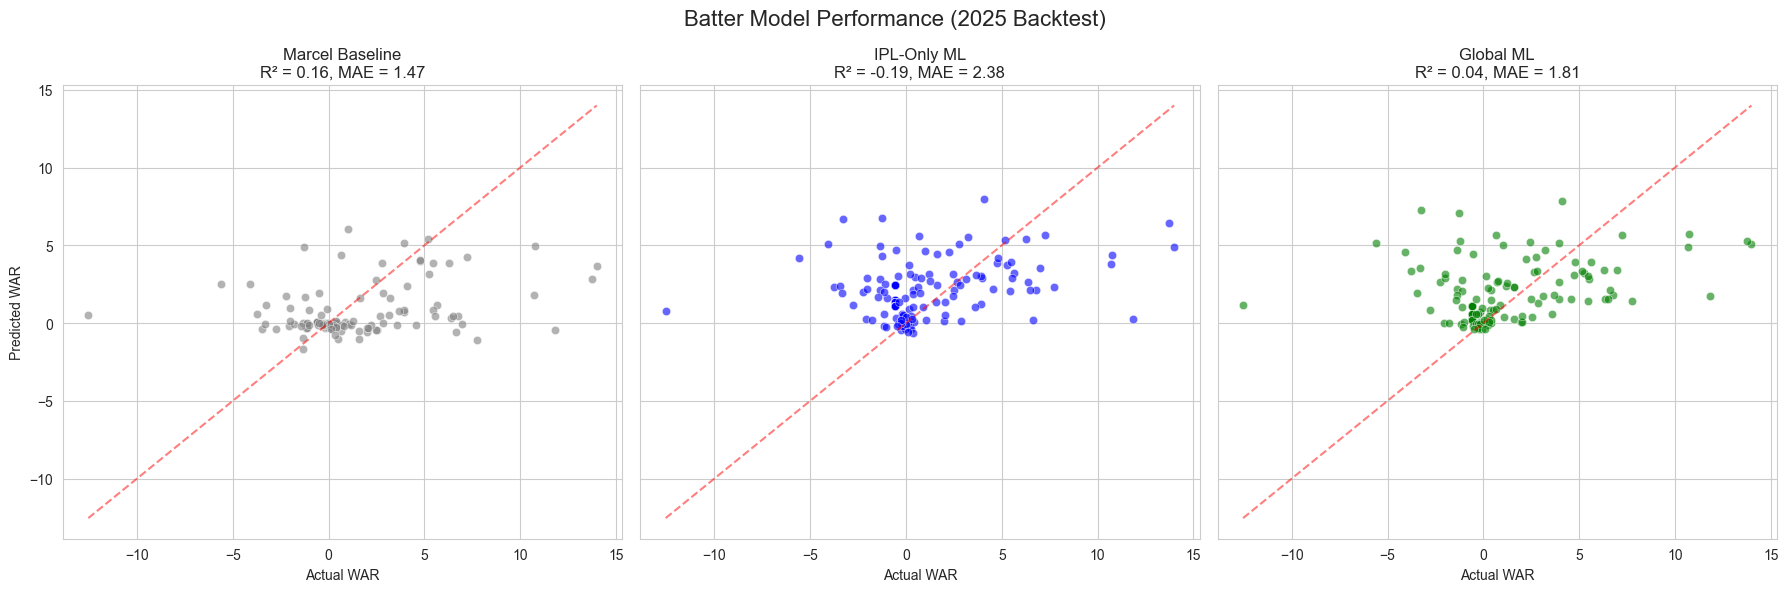

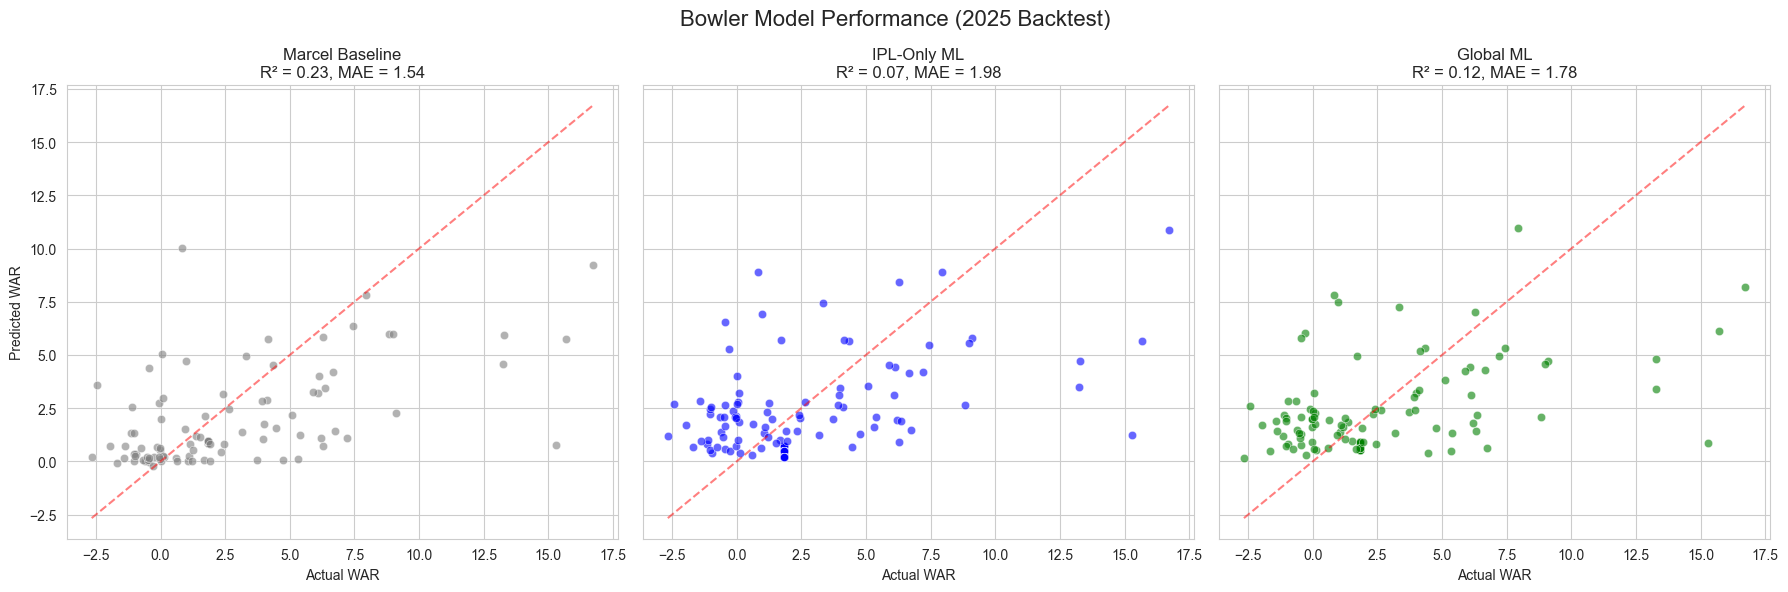

In [3]:
def plot_backtest(data, role):
    """Plot Actual vs Predicted for all models."""
    actual = data[role]['actual']
    backtests = data[role]['backtest']
    
    merged = actual
    for name, df in backtests.items():
        merged = merged.merge(df, on='player_name', how='inner')
        
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f'{role.capitalize()} Model Performance (2025 Backtest)', fontsize=16)
    
    models = ['marcel', 'ipl_ml', 'global_ml']
    titles = ['Marcel Baseline', 'IPL-Only ML', 'Global ML']
    colors = ['gray', 'blue', 'green']
    
    for i, model in enumerate(models):
        ax = axes[i]
        col = f'{model}_war'
        
        # Metrics
        r2 = r2_score(merged['actual_war'], merged[col])
        mae = mean_absolute_error(merged['actual_war'], merged[col])
        
        sns.scatterplot(data=merged, x='actual_war', y=col, ax=ax, color=colors[i], alpha=0.6)
        
        # Perfect prediction line
        lims = [min(merged['actual_war'].min(), merged[col].min()), 
                max(merged['actual_war'].max(), merged[col].max())]
        ax.plot(lims, lims, 'r--', alpha=0.5)
        
        ax.set_title(f"{titles[i]}\nR² = {r2:.2f}, MAE = {mae:.2f}")
        ax.set_xlabel("Actual WAR")
        if i == 0:
            ax.set_ylabel("Predicted WAR")
            
    plt.tight_layout()
    plt.show()

plot_backtest(data, 'batter')
plot_backtest(data, 'bowler')

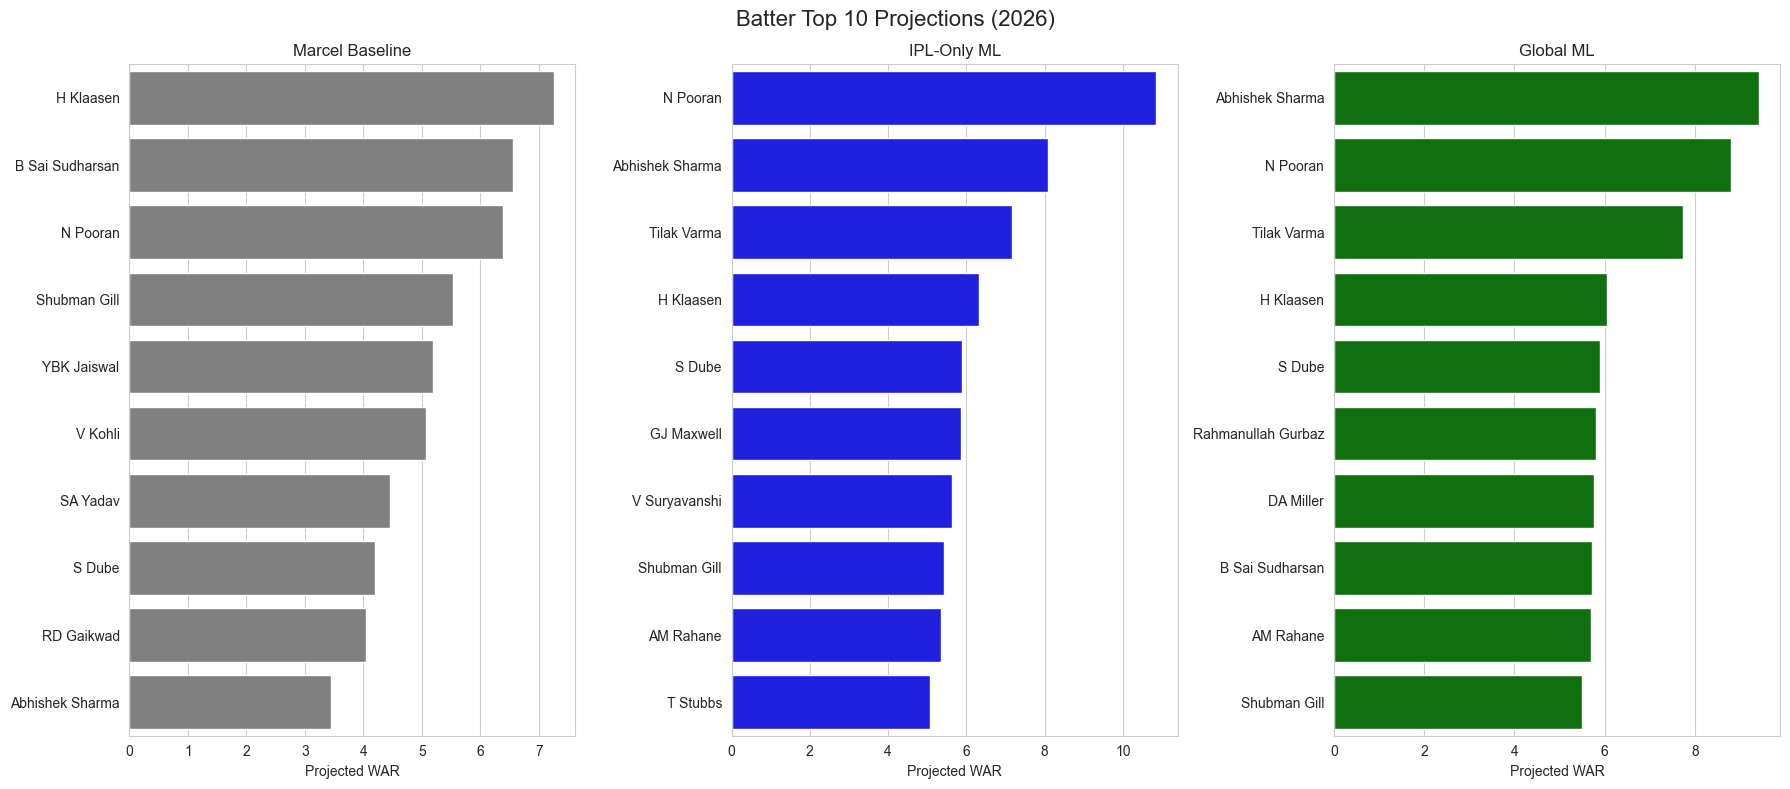

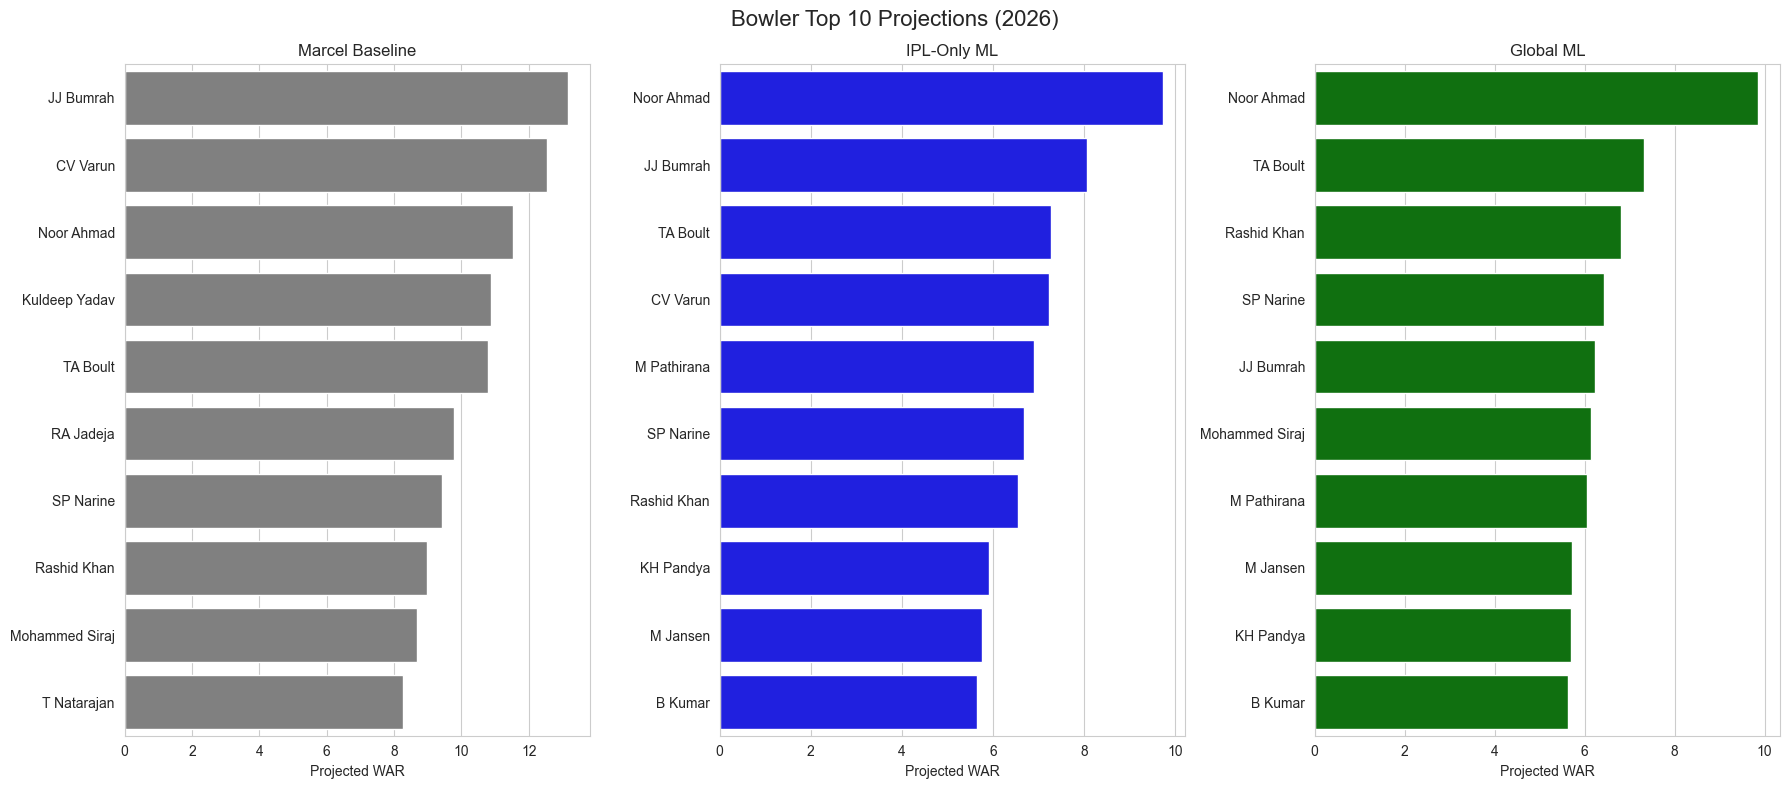

In [4]:
def plot_top_projections(data, role):
    """Plot Top 10 Projected Players for 2026."""
    forecasts = data[role]['forecast']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    fig.suptitle(f'{role.capitalize()} Top 10 Projections (2026)', fontsize=16)
    
    models = ['marcel', 'ipl_ml', 'global_ml']
    titles = ['Marcel Baseline', 'IPL-Only ML', 'Global ML']
    colors = ['gray', 'blue', 'green']
    
    for i, model in enumerate(models):
        ax = axes[i]
        df = forecasts[model].sort_values(f'{model}_war', ascending=False).head(10)
        
        sns.barplot(data=df, y='player_name', x=f'{model}_war', ax=ax, color=colors[i], orient='h')
        ax.set_title(titles[i])
        ax.set_xlabel("Projected WAR")
        ax.set_ylabel("")
        
    plt.tight_layout()
    plt.show()

plot_top_projections(data, 'batter')
plot_top_projections(data, 'bowler')